In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.linalg import svd

### **Hamiltonian System Overview**

This section simulates a two-chain spin system interacting with an external magnetic field. The system is composed of two distinct spin chains and a central witness spin. By constructing and analyzing the Hamiltonian for this system, we can explore its quantum behavior under different interactions and external fields.

The system consists of:

- **Chain 1**: Contains $N_1$ spins.
- **Chain 2**: Contains $N_2$ spins.
- **Central Witness Spin**: Denoted as $\sigma_0$, this spin interacts with both chains.

### **Hamiltonian Definition**

The Hamiltonian $\mathbf{H}$ governs the system’s evolution. It is defined as:


\begin{aligned}
\mathbf{H} = & - g_1 \mu_B H \sum_{n=1}^{N_1} S_{1,n}^z 
& - g_2 \mu_B H \sum_{n=1}^{N_2} S_{2,n}^z 
& - g_0 \mu_B H \sigma_0^z 
 - J_1 \sum_{n=1}^{N_1 - 1} \left( S_{1,n}^x S_{1,n+1}^x + S_{1,n}^y S_{1,n+1}^y \right) 
& - J_2 \sum_{n=1}^{N_2 - 1} \left( S_{2,n}^x S_{2,n+1}^x + S_{2,n}^y S_{2,n+1}^y \right) 
& - J_0 \sigma_0^z \left( S_{1,N_1}^z + S_{2,1}^z + S_{2,N_2}^z \right).
\end{aligned}

This Hamiltonian includes the following key components:

- **Zeeman Terms**: The first three terms represent the interaction of the spins with the external magnetic field $H$. Each spin in Chain 1, Chain 2, and the witness spin $\sigma_0$ is affected by this field. The coupling constants $g_1$, $g_2$, and $g_0$ modulate the strength of the interaction with the field for the respective spins.
  
- **Interaction Terms Within Chains**: The fourth and fifth terms represent nearest-neighbor interactions within Chain 1 and Chain 2. The Pauli-X ($S_x$) and Pauli-Y ($S_y$) operators describe the spin-spin couplings, which determine how spins in the same chain influence each other.

- **Interaction with Central Spin**: The final term describes the interaction between the central witness spin $\sigma_0$ and the spins at the ends of Chain 1 and Chain 2. This coupling is governed by the constant $J_0$ and contributes to how the central spin interacts with its neighbors.

---

### **System Visualization**

To better understand the structure, you can visualize the system as follows:

- **Chain 1**: A line of $N_1$ spins, each interacting with its nearest neighbor.
- **Chain 2**: Another line of $N_2$ spins, also interacting with nearest neighbors.
- **Central Witness Spin**: A single spin $\sigma_0$ placed between Chain 1 and Chain 2, interacting with both chains.

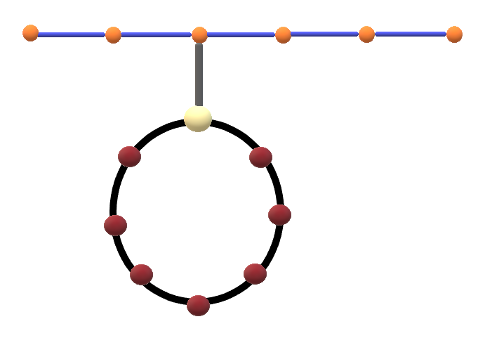
<!-- ![Alt text](path_to_your_image.png) -->
<!-- Optionally include a system diagram here. -->

### **Pauli Matrices and System Parameters**

The system's dynamics are defined using the Pauli matrices, which describe the quantum states of spins. Additionally, key physical parameters govern the interactions and external influences on the system:

#### **Pauli Matrices**:
- $S_x$: Pauli-X matrix, representing spin-flip operations.
- $S_y$: Pauli-Y matrix, representing phase-flip operations.
- $S_z$: Pauli-Z matrix, representing spin alignment along the $z$-axis.
- **Identity**: The $2 \times 2$ identity matrix ($I_2$) used for constructing multi-spin operators.

#### **System Parameters**:
- **$N_1, N_2$**: Number of spins in Chain 1 and Chain 2, respectively.
- **$g_1, g_2, g_0$**: Coupling constants governing the interaction between the spins and the external magnetic field for Chain 1, Chain 2, and the central witness spin.
- **$\mu_B$**: Bohr magneton, which sets the scale for the magnetic interactions.
- **$H_{\text{field}}$**: Strength of the external magnetic field applied to the system.
- **$J_1, J_2, J_0$**: Spin coupling constants that control the strength of the interactions within Chain 1, Chain 2, and between the central witness spin and its neighbors.

The total number of spins in the system is:

$$ N = N_1 + N_2 + 1 $$

The additional $1$ represents the central witness spin $\sigma_0$. This definition ensures the Hamiltonian acts on the entire system of spins.



In [2]:
def initialize_system():
    """Initialize system parameters and Pauli matrices."""
    global sx, sy, sz, identity
    global N1, N2, g1, g2, g0, muB, H_field, J1, J2, J0, N
    
    # Pauli matrices
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)
    identity = np.eye(2, dtype=complex)

    # System parameters
    N1 = 5  # Number of spins in the first chain
    N2 = 4  # Number of spins in the second chain
    g1, g2, g0 = 1.0, 1.0, 1.0  # Coupling constants
    muB = 1.0  # Bohr magneton
    H_field = 0.0  # External magnetic field
    J1, J2, J0 = 1.0, 1.0, 1.0  # Spin coupling constants

    # Total number of spins (sigma_0 + chain 1 + chain 2)
    N = N1 + N2 + 1  # +1 for sigma_0

initialize_system()

# Kronecker Product Function
The `kron_n` function is used to efficiently construct large operators that act on the entire spin system. By using the Kronecker product of single-site operators, we can apply various operations (like external fields or spin interactions) to the whole system. This step is crucial for the scalability of the simulation, as manually constructing these large matrices would be inefficient and error-prone.

The sparse matrix format is used to save memory and ensure faster computation in large systems, making this approach efficient for quantum many-body problems.


In [3]:
def kron_n(op_list):
    """Create a Kronecker product of a list of operators."""
    result = op_list[0]
    for op in op_list[1:]:
        result = sp.kron(result, op, format='csr')
    return result


### **Building the Hamiltonian**

This function constructs the full Hamiltonian for our two-chain spin system interacting with an external magnetic field. The Hamiltonian governs the dynamics and evolution of the system by describing both the external field influence on the spins and the interactions between them.

The process is broken down into several key steps:

1. **Hilbert Space Setup**:  
   We begin by determining the dimension of the Hilbert space, which is $2^N$, where $N$ is the total number of spins in the system (the spins from Chain 1, Chain 2, and the witness spin $\sigma_0$). The Hamiltonian matrix is initialized as a sparse matrix to efficiently handle its potentially large size.

2. **External Field Terms**:  
   The external magnetic field interacts with each spin in the system, contributing to the overall energy. This is calculated separately for:
   - The central witness spin $\sigma_0$.
   - Each spin in Chain 1 and Chain 2.

3. **Interaction Terms within Chains**:  
   The spins in each chain interact with their nearest neighbors via Pauli-X ($S_x$) and Pauli-Y ($S_y$) operators. This step describes the spin-spin interactions within each chain, which are essential for capturing the system's internal dynamics.

4. **Interaction Between Witness Spin and Chains**:  
   The witness spin $\sigma_0$ interacts with a specified spin in Chain 1, as well as the first and last spins of Chain 2. This cross-chain interaction helps model how the two chains communicate through the witness spin.

5. **Periodic Boundary Conditions**:  
   For Chain 2, periodic boundary conditions are implemented, meaning that the first and last spins are also considered neighbors, closing the loop of interactions within Chain 2.

Each step adds a piece of the total Hamiltonian matrix. The function is structured to be flexible and modular, allowing the system's parameters (such as coupling constants or the external field) to be easily adjusted for different physical scenarios.

By building the Hamiltonian in this piecewise manner, we capture both local and long-range interactions, making it a comprehensive model for studying the quantum behavior of this spin system.

In [4]:
def build_hamiltonian(verbose=False, connected_spin_index=2, H_field=1.0, J0=1.0):
    """Build the Hamiltonian for the system."""
    if verbose:
        print("Building Hamiltonian...")
    D = 2**N  # Dimension of the Hilbert space
    if verbose:
        print(f"Total number of spins N = {N}, Hilbert space dimension D = {D}")
    
    # Initialize Hamiltonian
    H_total = sp.csr_matrix((D, D), dtype=complex)
    
    # External field term for sigma_0 (witness spin)
    if verbose:
        print("Adding external field term for witness spin...")
    op_list = [identity]*N
    op_list[N1] = sz  # Witness spin is at index N1
    sigma0_z = kron_n(op_list)
    H_sigma0 = -g0 * muB * H_field * sigma0_z
    H_total += H_sigma0
    
    # External field terms for Chain 1
    if verbose:
        print("Adding external field terms for Chain 1...")
    for i in range(N1):
        op_list = [identity]*N
        op_list[i] = sz
        term = -g1 * muB * H_field * kron_n(op_list)
        H_total += term
    
    # External field terms for Chain 2
    if verbose:
        print("Adding external field terms for Chain 2...")
    for i in range(N2):
        op_list = [identity]*N
        op_list[N1 + 1 + i] = sz  # Chain 2 starts after sigma_0
        term = -g2 * muB * H_field * kron_n(op_list)
        H_total += term
    
    # Interaction terms within Chain 1
    if verbose:
        print("Adding interaction terms within Chain 1...")
    for i in range(N1 - 1):
        for op in [sx, sy]:
            op_list = [identity]*N
            op_list[i] = op
            op_list[i+1] = op
            H_total += -J1 * kron_n(op_list)
    
    # Interaction between witness spin and specified spin in Chain 1
    if verbose:
        print("Adding interaction between witness spin and specified spin in Chain 1...")
    witness_spin_index = N1  # Witness spin index
    op_list = [identity]*N
    op_list[witness_spin_index] = sz
    op_list[connected_spin_index] = sz  # Connected spin in Chain 1
    H_total += -J0 * kron_n(op_list)
    
    # Interaction terms within Chain 2 with periodic boundary conditions
    if verbose:
        print("Adding interaction terms within Chain 2 (circular)...")
    for i in range(N2):
        idx1 = N1 + 1 + i % N2
        idx2 = N1 + 1 + (i + 1) % N2
        for op in [sx, sy]:
            op_list = [identity]*N
            op_list[idx1] = op
            op_list[idx2] = op
            H_total += -J2 * kron_n(op_list)
    
    # Interaction between witness spin and Chain 2 spins
    if verbose:
        print("Adding interaction between witness spin and Chain 2 spins...")
    # Witness spin interacts with first and last spins of Chain 2
    for idx in [N1 + 1, N1 + N2]:
        op_list = [identity]*N
        op_list[witness_spin_index] = sz
        op_list[idx] = sz
        H_total += -J0 * kron_n(op_list)
    
    if verbose:
        print("Hamiltonian construction completed.")
    return H_total

# Diagonalizing the Hamiltonian
Once the Hamiltonian is built, the next step is to diagonalize it. Diagonalization allows us to find the eigenvalues and eigenvectors, which correspond to the energy levels and quantum states of the system. The function uses an efficient sparse diagonalization routine to handle the large matrix size.

The eigenvalues provide insight into the system's energy spectrum, while the eigenvectors are the quantum states that we will analyze further. This step is computationally intensive but is essential for understanding the system's quantum properties.


In [5]:
def diagonalize_hamiltonian(H):
    """Diagonalize the Hamiltonian and return sorted eigenvalues and eigenvectors."""
    print("Diagonalizing Hamiltonian...")
    eigenvalues, eigenvectors = spla.eigsh(H, k=100, which='SA')
    
    # Sort the eigenvalues and corresponding eigenvectors in ascending order
    sorted_indices = np.argsort(eigenvalues)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

# Main Execution and Initial Results
In this section, we bring everything together by initializing the system, constructing the Hamiltonian, and then diagonalizing it to obtain the energy levels. The system's energy spectrum tells us about its possible quantum states and helps identify degenerate states, which are important for understanding symmetry and phase transitions.

The identification of degenerate eigenstates is crucial, as it can indicate hidden symmetries or critical points in the system, especially when tuning parameters like the external magnetic field.


In [6]:
# MAIN FLOW
initialize_system()

# Build the Hamiltonian and explore eigenstates
H = build_hamiltonian(verbose=False, connected_spin_index=2)

# Diagonalize Hamiltonian to find ground state and explore degeneracy
eigenvalues, eigenvectors = diagonalize_hamiltonian(H)

# Output energy levels
print("Energy levels:")
for idx, energy in enumerate(eigenvalues):
    print(f"Level {idx+1}: {energy}")

# Calculate the difference between consecutive eigenvalues
eigenvalue_differences = np.diff(eigenvalues)

# Set a smaller tolerance for detecting true degeneracies
tolerance = 1e-8
degenerate_groups = []
current_group = [0]  # Start with the first eigenvalue

for i in range(1, len(eigenvalues)):
    if abs(eigenvalues[i] - eigenvalues[i-1]) < tolerance:
        current_group.append(i)
    else:
        if len(current_group) > 1:
            degenerate_groups.append(current_group)
        current_group = [i]

# Check the last group
if len(current_group) > 1:
    degenerate_groups.append(current_group)

if degenerate_groups:
    print(f"Degenerate eigenstates found in the following groups:")
    for group in degenerate_groups:
        group_indices = [idx + 1 for idx in group]  # Convert to 1-based indexing
        group_eigenvalues = [eigenvalues[idx] for idx in group]
        print(f"Eigenvalues {group_indices} are degenerate with value {group_eigenvalues[0]}")
else:
    print("No degenerate eigenstates found within the tolerance.")


Diagonalizing Hamiltonian...


Energy levels:
Level 1: -15.198456585684117
Level 2: -15.198456585684086
Level 3: -14.236067977500438
Level 4: -14.236067977500005
Level 5: -13.962388608184432
Level 6: -13.962388608184211
Level 7: -13.804007861148065
Level 8: -13.80400786114805
Level 9: -13.00000000000028
Level 10: -13.00000000000019
Level 11: -12.841619252964056
Level 12: -12.841619252963861
Level 13: -12.576240950752096
Level 14: -12.576240950752029
Level 15: -11.613852342568148
Level 16: -11.613852342567904
Level 17: -11.340172973252182
Level 18: -11.34017297325217
Level 19: -11.198456585683997
Level 20: -11.19845658568387
Level 21: -11.198456585683813
Level 22: -11.1984565856837
Level 23: -11.181792226216276
Level 24: -11.181792226215947
Level 25: -11.181792226215878
Level 26: -11.181792226215785
Level 27: -10.726320630684471
Level 28: -10.726320630684437
Level 29: -10.576240950752076
Level 30: -10.5762409507519
Level 31: -10.377784365068157
Level 32: -10.377784365068068
Level 33: -10.236067977499896
Level 34: -10

# Symmetry Analysis of Eigenstates
After obtaining the eigenstates from diagonalization, we analyze their parity symmetry. Parity symmetry reveals how the system behaves under spatial inversion (flipping the spins). Eigenstates with strong parity symmetry may indicate that the system is invariant under certain transformations, which can lead to deeper insights into its quantum properties.

Symmetry breaking is a hallmark of phase transitions, and tracking symmetry helps us detect such phenomena.

In [7]:
import scipy.sparse as sp

def build_parity_operator(N1, N2, N):
    """
    Constructs the total parity operator for a system with multiple spin chains.
    
    Parameters:
    - N1 (int): Number of spins in Chain 1.
    - N2 (int): Number of spins in Chain 2.
    - N (int): Total number of spins in the system (N1 + N2 + 1 for the witness spin).
    
    Returns:
    - P_total (scipy.sparse.csr_matrix): Total parity operator for the system.
    
    Description:
    This function constructs the parity operator by independently reversing the order of spins in each spin chain.
    The witness spin (located at index N1) remains unchanged under the parity operation.
    """
    # Define starting indices for each chain and witness spin
    chain1_start = 0
    witness_spin_index = N1
    chain2_start = N1 + 1
    
    row_indices = []
    col_indices = []
    data = []
    
    for i in range(2**N):
        # Convert the integer index to a binary string with leading zeros
        bits = bin(i)[2:].zfill(N)
        
        # Extract and reverse bits for Chain 1
        chain1_bits = bits[chain1_start:chain1_start + N1]
        reversed_chain1_bits = chain1_bits[::-1]
        
        # Extract the witness spin bit (remains unchanged)
        witness_bit = bits[witness_spin_index]
        
        # Extract and reverse bits for Chain 2
        chain2_bits = bits[chain2_start:chain2_start + N2]
        reversed_chain2_bits = chain2_bits[::-1]
        
        # Reconstruct the new bit string with reversed chains and unchanged witness spin
        new_bits = reversed_chain1_bits + witness_bit + reversed_chain2_bits
        
        # Convert the new bit string back to an integer index
        j = int(new_bits, 2)
        
        # Populate the row, column, and data lists for the sparse matrix
        row_indices.append(i)
        col_indices.append(j)
        data.append(1)
    
    # Create the sparse parity operator matrix in CSR format
    P_total = sp.csr_matrix((data, (row_indices, col_indices)), shape=(2**N, 2**N), dtype=complex)
    
    return P_total
P = build_parity_operator(N1, N2, N)

In [8]:
P_squared = P.dot(P)
identity_matrix = sp.identity(2**N, format='csr', dtype=complex)
difference = np.linalg.norm(P_squared.toarray() - identity_matrix.toarray())
print(f"Difference for P^2 - I= {difference}")

if difference < 1e-6:
    print("Parity operator satisfies P^2 = I.")
else:
    print("Parity operator does not satisfy P^2 = I. Check definition.")

Difference for P^2 - I= 0.0
Parity operator satisfies P^2 = I.


In [9]:
commutator = H.dot(P) - P.dot(H)
commutator_norm = spla.norm(commutator)
print(f"Commutator norm [H, P]: {commutator_norm}")

if commutator_norm < 1e-6:
    print("Hamiltonian commutes with parity operator. Parity symmetry confirmed.")
else:
    print("Hamiltonian does not commute with parity operator. Parity symmetry violated.")


Commutator norm [H, P]: 0.0
Hamiltonian commutes with parity operator. Parity symmetry confirmed.


In [10]:
def diagonalize_with_parity(eigenvalues, eigenvectors, P, tolerance=1e-2):
    """Diagonalize P within degenerate subspaces of H."""
    # Group indices of degenerate eigenvalues
    degenerate_groups = {}
    for idx, eigenvalue in enumerate(eigenvalues):
        # Use a tolerance to account for numerical precision
        key = np.round(eigenvalue / tolerance) * tolerance
        degenerate_groups.setdefault(key, []).append(idx)

    # Initialize a list to hold the new eigenvectors
    new_eigenvectors = eigenvectors.copy()

    for indices in degenerate_groups.values():
        if len(indices) > 1:
            # Extract the degenerate eigenvectors
            deg_vectors = eigenvectors[:, indices]
            # Form the matrix representation of P in this subspace
            P_subspace = deg_vectors.conj().T @ P @ deg_vectors
            # Diagonalize P in this subspace
            eigvals_P, eigvecs_P = np.linalg.eigh(P_subspace)
            # Construct the new eigenvectors with definite parity
            new_vectors = deg_vectors @ eigvecs_P
            # Update the eigenvectors
            for i, idx in enumerate(indices):
                new_eigenvectors[:, idx] = new_vectors[:, i]

    return new_eigenvectors

# Use the function to get eigenvectors with definite parity
eigenvectors_with_parity = diagonalize_with_parity(eigenvalues, eigenvectors, P.toarray())

def check_parity_symmetry(eigenvectors, P, tolerance=1e-8):
    """Check the parity symmetry of each eigenstate."""
    print("\nChecking parity symmetry of the eigenstates...")
    for idx in range(eigenvectors.shape[1]):
        psi = eigenvectors[:, idx]
        # Compute <psi|P|psi>
        parity_value = np.vdot(psi, P.dot(psi))
        # Take the real part
        parity_real = np.real(parity_value)
        
        # Classify parity based on the expectation value
        if np.abs(parity_real - 1) < tolerance:
            parity = "Even"
        elif np.abs(parity_real + 1) < tolerance:
            parity = "Odd"
        else:
            parity = "No definite parity"
        
        print(f"Eigenstate {idx+1} has parity: {parity} (Value: {parity_real})")

# # Check parity symmetry
# check_parity_symmetry(eigenvectors, P, tolerance=1e-8)

# Now check the parity symmetry of the new eigenvectors
check_parity_symmetry(eigenvectors_with_parity, P, tolerance=1e-2)


Checking parity symmetry of the eigenstates...
Eigenstate 1 has parity: No definite parity (Value: 0.6705874242794043)
Eigenstate 2 has parity: No definite parity (Value: 1.3294125757206285)
Eigenstate 3 has parity: Odd (Value: -0.9999266079245095)
Eigenstate 4 has parity: Even (Value: 1.0000733847242351)
Eigenstate 5 has parity: Even (Value: 0.9993959436141283)
Eigenstate 6 has parity: Even (Value: 1.0006040563859155)
Eigenstate 7 has parity: Even (Value: 0.9917079377166704)
Eigenstate 8 has parity: Even (Value: 1.008292062283363)
Eigenstate 9 has parity: Odd (Value: -1.0005959902439234)
Eigenstate 10 has parity: Even (Value: 0.9994027998681343)
Eigenstate 11 has parity: Odd (Value: -1.000333495432182)
Eigenstate 12 has parity: Even (Value: 0.9996664372821824)
Eigenstate 13 has parity: Odd (Value: -1.0000678221517925)
Eigenstate 14 has parity: Even (Value: 0.9999321420988136)
Eigenstate 15 has parity: Even (Value: 0.9989941359919907)
Eigenstate 16 has parity: Even (Value: 1.001005864

### Physical Insight

**Spin inversion symmetry** (also known as spin-flip symmetry) involves flipping all spins along a particular axis. For spins represented along the $z$-axis, the spin inversion operator $I$ flips the spin states from up to down and vice versa.

**Main Formula**:

- **Spin Inversion Operator**: $I = \bigotimes_{i=1}^N \sigma_i^x$
- **Spin Inversion Symmetry Condition**:$[H, I] = 0$
- **Operator Property**: $I^2 = I \otimes I = I^{\otimes 2} = I$

In [11]:
def build_spin_inversion_operator(N):
    """
    Constructs the spin inversion operator for all spins.
    
    Parameters:
    - N (int): Total number of spins in the system.
    
    Returns:
    - I_total (scipy.sparse.csr_matrix): Spin inversion operator.
    """
    op_list = [sx] * N
    I_total = kron_n(op_list)
    return I_total

# Build the spin inversion operator
I = build_spin_inversion_operator(N)


### Checking Spin Inversion Operator Properties

Verify that $I^2$ = $I \otimes I = I^{\otimes 2} = I$ (since $\sigma_x^2 = I$).

We will have it only for external magentic field = 0

In [12]:
# Check I^2 = I
I_squared = I.dot(I)
difference_I = np.linalg.norm(I_squared.toarray() - identity_matrix.toarray())
print(f"Difference for I^2 - I = {difference_I}")

if difference_I < 1e-6:
    print("Spin inversion operator satisfies I^2 = I.")
else:
    print("Spin inversion operator does not satisfy I^2 = I. Check definition.")


Difference for I^2 - I = 0.0
Spin inversion operator satisfies I^2 = I.


In [13]:
# Check [H, I] = 0
commutator_I = H.dot(I) - I.dot(H)
commutator_I_norm = spla.norm(commutator_I)
print(f"Commutator norm [H, I]: {commutator_I_norm}")

if commutator_I_norm < 1e-6:
    print("Hamiltonian commutes with spin inversion operator. Spin inversion symmetry confirmed.")
else:
    print("Hamiltonian does not commute with spin inversion operator. Spin inversion symmetry violated.")


Commutator norm [H, I]: 202.3857702507763
Hamiltonian does not commute with spin inversion operator. Spin inversion symmetry violated.


In [14]:
# Adjust eigenvectors to have definite spin inversion symmetry
eigenvectors_with_spin_inversion = diagonalize_with_parity(eigenvalues, eigenvectors, I)

# Check spin inversion symmetry
def check_spin_inversion_symmetry(eigenvectors, I, tolerance=1e-8):
    """Check the spin inversion symmetry of each eigenstate."""
    print("\nChecking spin inversion symmetry of the eigenstates...")
    for idx in range(eigenvectors.shape[1]):
        psi = eigenvectors[:, idx]
        # Compute <psi|I|psi>
        inversion_value = np.vdot(psi, I.dot(psi))
        # Take the real part
        inversion_real = np.real(inversion_value)
        
        # Classify based on the expectation value
        if np.abs(inversion_real - 1) < tolerance:
            symmetry = "Symmetric"
        elif np.abs(inversion_real + 1) < tolerance:
            symmetry = "Antisymmetric"
        else:
            symmetry = "No definite symmetry"
        
        print(f"Eigenstate {idx+1} has spin inversion symmetry: {symmetry} (Value: {inversion_real})")

# Check spin inversion symmetry
check_spin_inversion_symmetry(eigenvectors_with_spin_inversion, I, tolerance=1e-2)


Checking spin inversion symmetry of the eigenstates...
Eigenstate 1 has spin inversion symmetry: No definite symmetry (Value: -1.6034967187766117e-16)
Eigenstate 2 has spin inversion symmetry: No definite symmetry (Value: 4.571438509179344e-16)
Eigenstate 3 has spin inversion symmetry: No definite symmetry (Value: -5.893230008314075e-17)
Eigenstate 4 has spin inversion symmetry: No definite symmetry (Value: 3.5794963809613665e-18)
Eigenstate 5 has spin inversion symmetry: No definite symmetry (Value: -4.804191202916721e-17)
Eigenstate 6 has spin inversion symmetry: No definite symmetry (Value: 2.255399003031075e-17)
Eigenstate 7 has spin inversion symmetry: No definite symmetry (Value: -1.4031753396241424e-16)
Eigenstate 8 has spin inversion symmetry: No definite symmetry (Value: 3.3548205551444667e-15)
Eigenstate 9 has spin inversion symmetry: No definite symmetry (Value: 4.806939720833662e-18)
Eigenstate 10 has spin inversion symmetry: No definite symmetry (Value: 4.012687702680803e

# Time-Reversal Symmetry

### Physical Insight

**Time-reversal symmetry** involves reversing the direction of time in the system. In quantum mechanics, the time-reversal operator $T$ is anti-unitary and involves complex conjugation.

**Main Formula**:

- **Time-Reversal Operator**: $T = K$, where $K$ denotes complex conjugation.
- **Time-Reversal Symmetry Condition**: $[H, T] = 0$

In [15]:
# Check if the Hamiltonian is real
H_real = H.toarray()
if np.allclose(H_real, H_real.conj()):
    print("Hamiltonian is real. Time-reversal symmetry is present.")
else:
    print("Hamiltonian is complex. Time-reversal symmetry may be broken.")

# Alternatively, check [H, T] = 0
# Since T involves complex conjugation, we can check if H commutes with complex conjugation
H_T = H_real.conj()
commutator_T = H_real @ H_T - H_T @ H_real
commutator_T_norm = np.linalg.norm(commutator_T)
print(f"Commutator norm [H, T]: {commutator_T_norm}")

if commutator_T_norm < 1e-6:
    print("Hamiltonian commutes with time-reversal operator. Time-reversal symmetry confirmed.")
else:
    print("Hamiltonian does not commute with time-reversal operator. Time-reversal symmetry violated.")

Hamiltonian is real. Time-reversal symmetry is present.


Commutator norm [H, T]: 0.0
Hamiltonian commutes with time-reversal operator. Time-reversal symmetry confirmed.


# $U_{(1)}$ Symmetry (Conservation of Total $S^z$)

## Physical Insight

**U(1) symmetry** corresponds to conservation of the total spin component along a particular axis, typically the $z$-axis. In quantum spin systems, if the Hamiltonian commutes with the total $S^z$ operator, the system exhibits U(1) symmetry, and the total $S^z$ is conserved.

**Main Formula**:

- **Total $S^z$ Operator**:
$S^z_{\text{total}} = \sum_{i} S^z_i$
- **U(1) Symmetry Condition**:
$[H, S^z_{\text{total}}] = 0$

## Checking $U_{(1)}$ Symmetry

We will construct the total $S^z$ operator and check if it commutes with the Hamiltonian.

In [16]:
# Construct the total S^z operator
def build_total_Sz_operator(N):
    """Constructs the total S^z operator for all spins."""
    D = 2**N  # Dimension of the Hilbert space
    S_z_total = sp.csr_matrix((D, D), dtype=complex)
    for i in range(N):
        op_list = [identity]*N
        op_list[i] = sz
        S_z_i = kron_n(op_list)
        S_z_total += S_z_i
    return S_z_total

# Build the total S^z operator
S_z_total = build_total_Sz_operator(N)

# Check [H, S_z_total] = 0
commutator_Sz = H.dot(S_z_total) - S_z_total.dot(H)
commutator_Sz_norm = spla.norm(commutator_Sz)
print(f"Commutator norm [H, S_z_total]: {commutator_Sz_norm}")

if commutator_Sz_norm < 1e-6:
    print("Hamiltonian commutes with total S^z operator. U(1) symmetry confirmed.")
else:
    print("Hamiltonian does not commute with total S^z operator. U(1) symmetry is broken.")


Commutator norm [H, S_z_total]: 0.0
Hamiltonian commutes with total S^z operator. U(1) symmetry confirmed.


# Plotting the Energy Spectrum
Visualizing the energy spectrum gives a clear picture of the system's quantum state distribution. By plotting the eigenvalues, we can easily identify gaps in the spectrum (important for understanding quantum phase transitions) and see how the energy levels are distributed.

Energy gaps, especially between the ground state and excited states, can give insight into the stability of the system and whether it is in a critical phase.


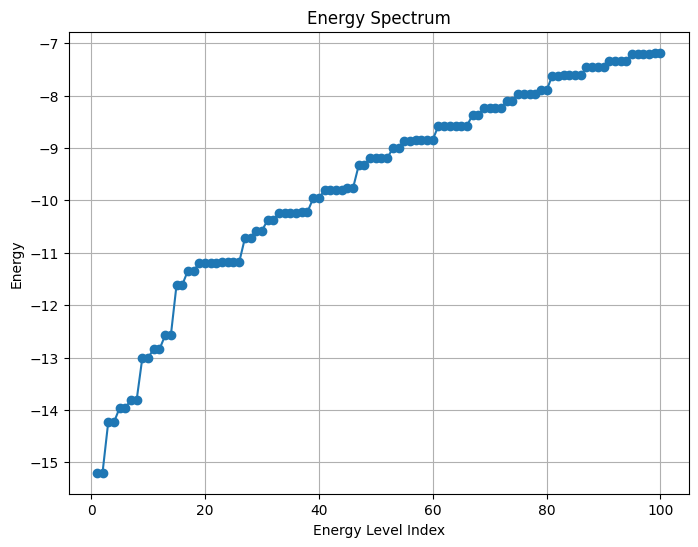

In [17]:
def plot_energy_spectrum(eigenvalues):
    """Plot the energy spectrum."""
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-')
    plt.xlabel('Energy Level Index')
    plt.ylabel('Energy')
    plt.title('Energy Spectrum')
    plt.grid(True)
    plt.show()

# Plot the energy spectrum
plot_energy_spectrum(eigenvalues)

# Calculating and Plotting Magnetization
The magnetization ⟨Sᶻ⟩ measures how much each spin aligns with the external magnetic field. By calculating this for each spin in the ground state, we can understand how the external field affects the system at a microscopic level. This is especially important for detecting ordered phases (like ferromagnetism) and understanding how individual spins behave under different conditions.

By plotting the magnetization for each spin, we can easily visualize how the chains respond to the external field and spin-spin interactions.


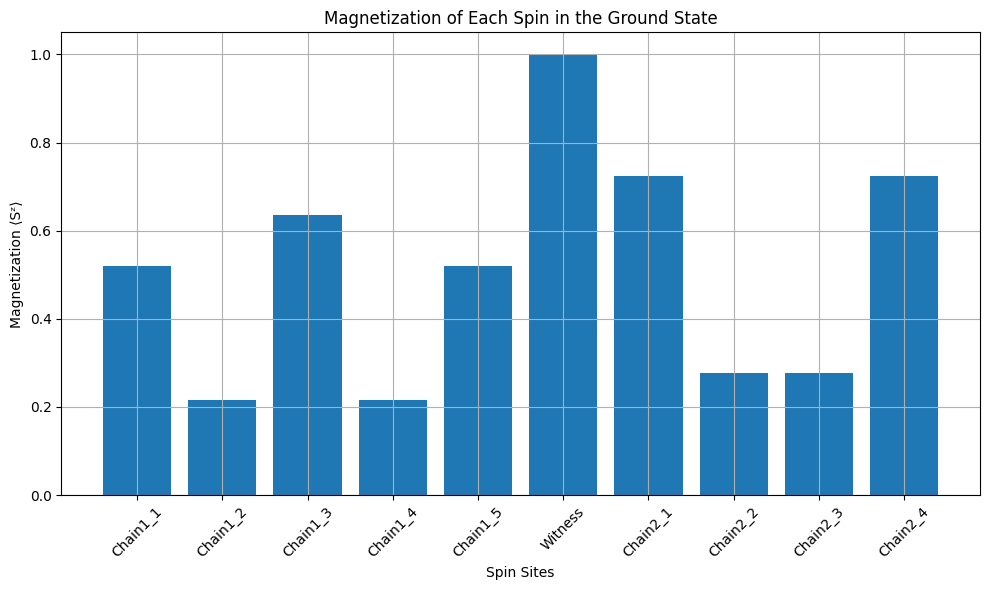

In [18]:
def compute_magnetization(ground_state):
    """Compute the magnetization for each spin in the system."""
    magnetizations = []
    for site in range(N):
        op_list = [identity] * N
        op_list[site] = sz  # Set sz at the current site
        S_z = kron_n(op_list)
        mag = np.vdot(ground_state, S_z.dot(ground_state)).real
        magnetizations.append(mag)
    return magnetizations


# Compute the magnetization
ground_state = eigenvectors[:, 0]  # The ground state is the first eigenvector
magnetizations = compute_magnetization(ground_state)

def plot_magnetization(magnetizations):
    """Plot the magnetization of each spin."""
    spin_labels = []
    for site in range(N):
        if site < N1:
            spin_labels.append(f'Chain1_{site+1}')
        elif site == N1:
            spin_labels.append('Witness')
        else:
            spin_labels.append(f'Chain2_{site - N1}')
    plt.figure(figsize=(10, 6))
    plt.bar(spin_labels, magnetizations)
    plt.xlabel('Spin Sites')
    plt.ylabel('Magnetization ⟨Sᶻ⟩')
    plt.title('Magnetization of Each Spin in the Ground State')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plot the magnetization
plot_magnetization(magnetizations)

# Spin-Spin Correlation
The spin-spin correlation function ⟨Sᶻᵢ Sᶻⱼ⟩ measures how the magnetic moment of one spin is related to another at different positions. This helps in understanding long-range correlations, which are essential for detecting quantum phase transitions and the presence of entanglement in the system.

Strong correlations between distant spins may indicate quantum coherence or the presence of an ordered phase, making this an essential tool for analyzing many-body quantum systems.


Computing spin-spin correlation functions...


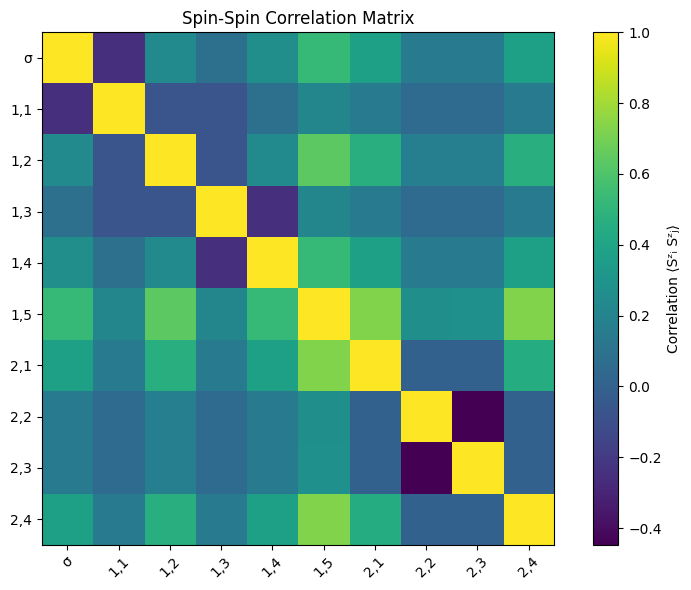

In [19]:
def compute_spin_spin_correlation(ground_state):
    """Compute the spin-spin correlation matrix for the system."""
    print("Computing spin-spin correlation functions...")
    
    spin_indices = range(N)  # All spins
    correlations = np.zeros((N, N))

    for i in spin_indices:
        for j in spin_indices:
            op_list_i = [identity]*N
            op_list_i[i] = sz
            S_i_z = kron_n(op_list_i)
            
            op_list_j = [identity]*N
            op_list_j[j] = sz
            S_j_z = kron_n(op_list_j)
            
            # Compute the correlation
            correlation_op = S_i_z.dot(S_j_z)
            corr = np.vdot(ground_state, correlation_op.dot(ground_state)).real
            correlations[i, j] = corr

    # Plot correlation matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(correlations, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Correlation ⟨Sᶻᵢ Sᶻⱼ⟩')
    spin_labels = ['σ'] + [f'1,{i+1}' for i in range(N1)] + [f'2,{i+1}' for i in range(N2)]
    plt.xticks(range(N), spin_labels, rotation=45)
    plt.yticks(range(N), spin_labels)
    plt.title('Spin-Spin Correlation Matrix')
    plt.tight_layout()
    plt.show()

    return correlations

# Call the function to compute the spin-spin correlations
correlations = compute_spin_spin_correlation(ground_state)

## Computing Entanglement Entropy

The entanglement entropy quantifies the quantum entanglement between a subsystem and the rest of the system. We will compute the von Neumann entropy of the reduced density matrix of the subsystem.

In [20]:
def compute_entanglement_entropy(ground_state, subsystem_indices):
    """
    Compute the entanglement entropy of the ground state with respect to a subsystem.

    Parameters:
    - ground_state: numpy array of shape (2**N,)
    - subsystem_indices: list of spin indices included in the subsystem

    Returns:
    - entanglement entropy (float)
    """
    # Number of spins in the system
    N = int(np.log2(len(ground_state)))

    # Define the sizes of subsystem A and B
    subsystem_size = len(subsystem_indices)
    env_size = N - subsystem_size

    # Generate the list of all spin indices
    all_indices = list(range(N))

    # Compute the ordering of axes for reshaping
    # We need to move the subsystem indices to the front
    permute_order = subsystem_indices + [i for i in all_indices if i not in subsystem_indices]

    # Reshape the ground state into a tensor
    psi_tensor = ground_state.reshape([2]*N)

    # Permute the axes
    psi_tensor = np.transpose(psi_tensor, permute_order)

    # Reshape into a matrix suitable for partial trace
    psi_matrix = psi_tensor.reshape(2**subsystem_size, 2**env_size)

    # Compute the reduced density matrix by tracing out the environment
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)

    # Compute eigenvalues of rho_A
    eigenvalues = np.linalg.eigvalsh(rho_A)

    # Compute the von Neumann entropy
    # Avoid log(0) by adding a small epsilon
    epsilon = 1e-12
    eigenvalues = np.clip(eigenvalues, epsilon, 1.0)
    entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))

    return entanglement_entropy


## Sweeping the External Magnetic Field $H_{\text{field}}$

We will vary $H_{\text{field}}$ and observe its effect on the entanglement entropy and magnetization.

In [36]:
# Define the range of H_field values
H_field_values = np.linspace(-10, 10, 100)  # From 0 to 2 in 20 steps

# Arrays to store results
entanglement_entropies = []
witness_magnetizations = []

for H_field_value in H_field_values:
    # Build the Hamiltonian with the current H_field value
    H = build_hamiltonian(verbose=False, connected_spin_index=2, H_field=H_field_value)
    
    # Compute the ground state
    eigenvalues, eigenvectors = spla.eigsh(H, k=1, which='SA')
    ground_state = eigenvectors[:, 0]
    
    # Compute magnetization
    magnetizations = compute_magnetization(ground_state)
    witness_magnetizations.append(magnetizations[N1])  # Witness spin at index N1
    
    # Compute entanglement entropy between the witness spin and the rest
    entropy = compute_entanglement_entropy(ground_state, subsystem_indices=[N1])
    entanglement_entropies.append(entropy)

In [37]:
print(entanglement_entropies)

[np.float64(2.7631021115928546e-11), np.float64(2.763113213823101e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631909294348246e-11), np.float64(2.7631021115928546e-11), np.float64(2.763213133895317e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.763168724974332e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631354182835933e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.763157622744086e-11), np.float64(2.7632686450465484e-11), np.float64(2.7631021115928546e-11), np.float64(2.7633241561977796e-11), np.float64(2.7631021115928546e-11), np.float64(2.763290849507041e-11), np.float64(2.7631021115928546e-11), np.float64(2.7631021115928546e-11), np.float64(2.7632353383558096e-1

In [38]:
print(H_field_values)

[-10.          -9.7979798   -9.5959596   -9.39393939  -9.19191919
  -8.98989899  -8.78787879  -8.58585859  -8.38383838  -8.18181818
  -7.97979798  -7.77777778  -7.57575758  -7.37373737  -7.17171717
  -6.96969697  -6.76767677  -6.56565657  -6.36363636  -6.16161616
  -5.95959596  -5.75757576  -5.55555556  -5.35353535  -5.15151515
  -4.94949495  -4.74747475  -4.54545455  -4.34343434  -4.14141414
  -3.93939394  -3.73737374  -3.53535354  -3.33333333  -3.13131313
  -2.92929293  -2.72727273  -2.52525253  -2.32323232  -2.12121212
  -1.91919192  -1.71717172  -1.51515152  -1.31313131  -1.11111111
  -0.90909091  -0.70707071  -0.50505051  -0.3030303   -0.1010101
   0.1010101    0.3030303    0.50505051   0.70707071   0.90909091
   1.11111111   1.31313131   1.51515152   1.71717172   1.91919192
   2.12121212   2.32323232   2.52525253   2.72727273   2.92929293
   3.13131313   3.33333333   3.53535354   3.73737374   3.93939394
   4.14141414   4.34343434   4.54545455   4.74747475   4.94949495
   5.151515

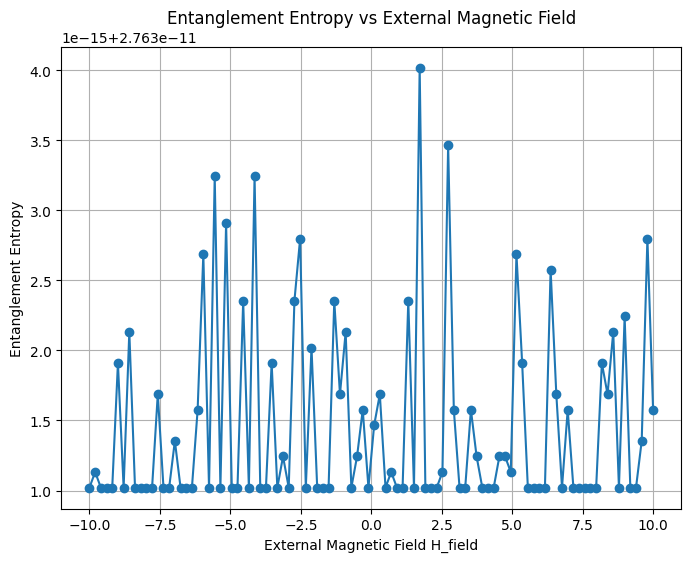

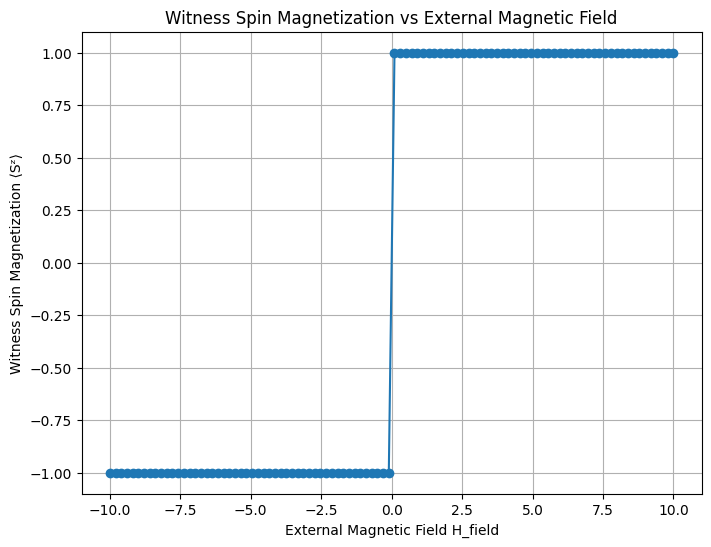

In [39]:
# Plot Entanglement Entropy vs H_field
plt.figure(figsize=(8, 6))
plt.plot(H_field_values, entanglement_entropies, marker='o')
plt.xlabel('External Magnetic Field H_field')
plt.ylabel('Entanglement Entropy')
plt.title('Entanglement Entropy vs External Magnetic Field')
plt.grid(True)
plt.show()

# Plot Witness Spin Magnetization vs H_field
plt.figure(figsize=(8, 6))
plt.plot(H_field_values, witness_magnetizations, marker='o')
plt.xlabel('External Magnetic Field H_field')
plt.ylabel('Witness Spin Magnetization ⟨Sᶻ⟩')
plt.title('Witness Spin Magnetization vs External Magnetic Field')
plt.grid(True)
plt.show()

## Sweeping the Interaction Strength $J0$

Now, we will vary $J0$ while keeping  $H_{\text{field}}$ constant.

In [41]:
# Define the range of J0 values
J0_values = np.linspace(0, 2, 20)  # From 0 to 2 in 20 steps

# Arrays to store results
entanglement_entropies_J0 = []
witness_magnetizations_J0 = []

for J0_value in J0_values:
    # Build the Hamiltonian with the current J0 value
    H = build_hamiltonian(verbose=False, connected_spin_index=2, H_field=1.0, J0=J0_value)
    
    # Compute the ground state
    eigenvalues, eigenvectors = spla.eigsh(H, k=1, which='SA')
    ground_state = eigenvectors[:, 0]
    
    # Compute magnetization
    magnetizations = compute_magnetization(ground_state)
    witness_magnetizations_J0.append(magnetizations[N1])  # Witness spin at index N1
    
    # Compute entanglement entropy between the witness spin and the rest
    entropy = compute_entanglement_entropy(ground_state, subsystem_indices=[N1])
    entanglement_entropies_J0.append(entropy)

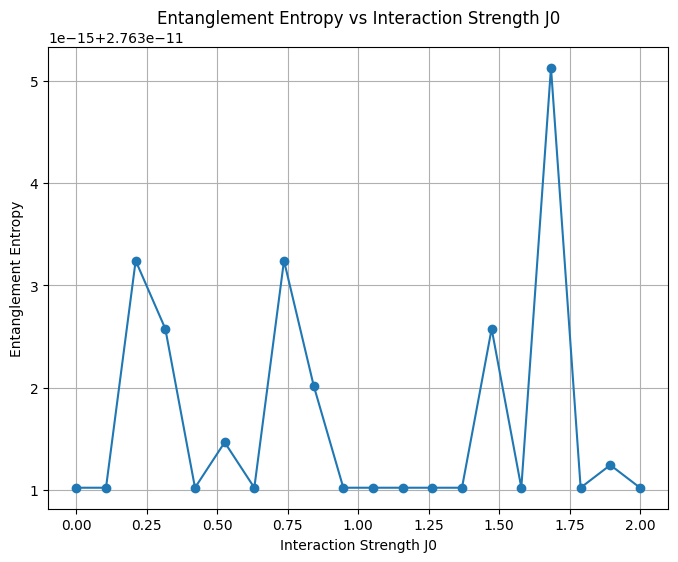

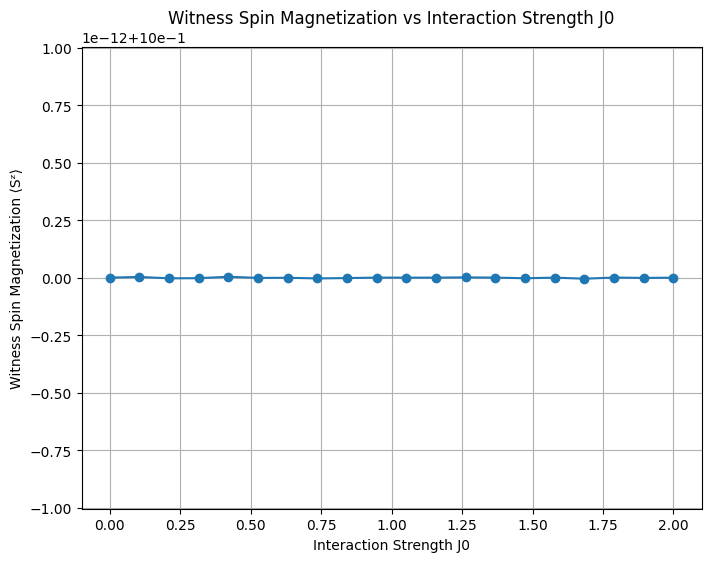

In [42]:
# Plot Entanglement Entropy vs J0
plt.figure(figsize=(8, 6))
plt.plot(J0_values, entanglement_entropies_J0, marker='o')
plt.xlabel('Interaction Strength J0')
plt.ylabel('Entanglement Entropy')
plt.title('Entanglement Entropy vs Interaction Strength J0')
plt.grid(True)
plt.show()

# Plot Witness Spin Magnetization vs J0
plt.figure(figsize=(8, 6))
plt.plot(J0_values, witness_magnetizations_J0, marker='o')
plt.xlabel('Interaction Strength J0')
plt.ylabel('Witness Spin Magnetization ⟨Sᶻ⟩')
plt.title('Witness Spin Magnetization vs Interaction Strength J0')
plt.grid(True)
plt.show()